# Download raw data

As linhas abaixo descrevem as etapas para fazer o _download_ dos dados programaticamente. Criem uma função para, dado um "massive id" baixar todos os arquivos mz(X)ML. 

In [ ]:
import ftplib

In [ ]:
url = "massive.ucsd.edu"
dr = "MSV000084628"

ftp = ftplib.FTP(url)
ftp.login("anonymous", "password")
ftp.cwd(dr)
ftp.nlst()

['ccms_metadata',
 'ccms_parameters',
 'ccms_peak',
 'metadata',
 'other',
 'peak',
 'updates']

In [ ]:
ftp.nlst('ccms_peak')

['ccms_peak/Hui_N1.mzML',
 'ccms_peak/Hui_N1_fe.mzML',
 'ccms_peak/Hui_N2.mzML',
 'ccms_peak/Hui_N2_fe.mzML',
 'ccms_peak/Hui_N3.mzML',
 'ccms_peak/Hui_N3_fe.mzML']

In [ ]:
ftp.retrbinary("RETR ccms_peak/Hui_N1.mzML", open("Hui_N1.mzML", 'wb').write)

'226 Transfer complete.'

In [ ]:
ftp.close()

# Reading and processing raw data

As linhas abaixo mostram como ler um arquivo de dados brutos e criar um cromatograma. A biblioteca [pyOpenMS](https://pyopenms.readthedocs.io/en/latest/) oferece várias funcionalidades que serão utilizadas nesse projeto. Crie uma função para, dado o nome de um arquivo, imprimir um cromatograma.

In [ ]:
!pip install pyopenms matplotlib

     |████████████████████████████████| 49.0 MB 114.4 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import os

from pyopenms import *

In [ ]:
os.listdir()

['.config', 'Hui_N1.mzML', 'sample_data']

In [ ]:
exp = MSExperiment()
MzMLFile().load('Hui_N1.mzML', exp)

exp

In [ ]:
tic = {} 
lmz = []
li = []
rt = []
for spec in exp:
    if spec.getMSLevel() == 1:
        mz, i = spec.get_peaks()
        lmz.append(mz)
        li.append(i)
        rt.append(spec.getRT())

tic['mz'] = lmz
tic['i'] = li
tic['rt'] = rt 

Text(0.5, 0, 'Retention Time')

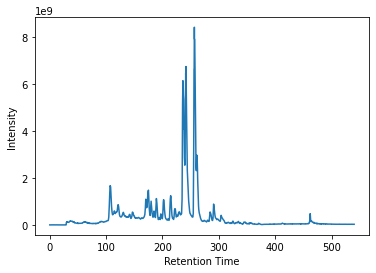

In [ ]:
plt.plot(tic['rt'], [x.sum() for x in tic['i']])
plt.ylabel('Intensity')
plt.xlabel('Retention Time')

# Retrieve processed data from GNPS

A rede criada com os dados pré-processados também pode ser acessada programaticamente. Ao acessar e manipular os resultados, aprendemos como estes estão estruturados, e como podemos reporduzi-los localmente (sem o gnps). Leiam o código abaixo e criem funções para acessar os resultados, dado um _jobid_ e como criar um grafo de um componente conectado ("família molecular").

In [ ]:
import pandas as pd
import requests
import io
#import xmltodict
import json

In [ ]:
# Resultados
# https://gnps.ucsd.edu/ProteoSAFe/status.jsp?task=8ca7cad8b792439588aa5c38051ed6d5

taskid = '8ca7cad8b792439588aa5c38051ed6d5'

url_to_attributes = "http://gnps.ucsd.edu/ProteoSAFe/DownloadResultFile?task=%s&block=main&file=clusterinfo_summary/" % taskid
url_to_db = "http://gnps.ucsd.edu/ProteoSAFe/DownloadResultFile?task=%s&block=main&file=DB_result/" % taskid
url_to_edges = "http://gnps.ucsd.edu/ProteoSAFe/DownloadResultFile?task=%s&block=main&file=networking_pairs_results_file_filtered/" % taskid
url_to_features = "http://gnps.ucsd.edu/ProteoSAFe/DownloadResultFile?task=%s&block=main&file=quantification_table/" % taskid
url_to_metadata = "http://gnps.ucsd.edu/ProteoSAFe/DownloadResultFile?task=%s&block=main&file=metadata_table/" % taskid
            
gnps = pd.read_csv(io.StringIO(requests.get(url_to_attributes).text), sep='\t')
dbmatch = pd.read_csv(io.StringIO(requests.get(url_to_db).text), sep='\t')
net = pd.read_csv(io.StringIO(requests.get(url_to_edges).text), sep='\t')
feat = pd.read_csv(io.StringIO(requests.get(url_to_features).text))
meta = pd.read_csv(io.StringIO(requests.get(url_to_metadata).text), sep='\t')


In [ ]:
dbmatch.head()

,SpectrumID,Compound_Name,Ion_Source,Instrument,Compound_Source,PI,Data_Collector,Adduct,Precursor_MZ,ExactMass,Charge,CAS_Number,Pubmed_ID,Smiles,INCHI,INCHI_AUX,Library_Class,IonMode,UpdateWorkflowName,LibraryQualityString,#Scan#,SpectrumFile,LibraryName,MQScore,Organism,TIC_Query,RT_Query,MZErrorPPM,SharedPeaks,MassDiff,LibMZ,SpecMZ,SpecCharge,FileScanUniqueID,NumberHits,tags,MoleculeExplorerDatasets,MoleculeExplorerFiles,InChIKey,InChIKey-Planar,superclass,class,subclass,npclassifier_superclass,npclassifier_class,npclassifier_pathway
0,CCMSLIB00005723621,Aerobactin,LC-ESI,Orbitrap,Lysate,Pieter Dorrestein,Allegra Aron,M+H,565.230,0.0,1,,,,,,3,Positive,UPDATE-SINGLE-ANNOTATED-BRONZE,Bronze,10,spectra_filtered/specs_ms.mgf,lib-00014.mgf,0.970116,GNPS-LIBRARY,1.412300e+09,0,8.314680,27,0.004700,565.230,565.235,1,spectra_filtered/specs_ms.mgf10,1,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CCMSLIB00003137732,"Spectral Match to 2,4,7,9-Tetramethyl-5-decyne...",ESI,HCD,Isolated,Data from Gabriel Haddad,Data deposited by mjmeehan,M+H-H2O,209.190,0.0,1,126863,NaN,NaN,NaN,NaN,3,Positive,UPDATE-SINGLE-ANNOTATED-BRONZE,Bronze,1035,spectra_filtered/specs_ms.mgf,lib-00036.mgf,0.913743,GNPS-NIST14-MATCHES,3.050000e+06,0,0.510596,8,0.000107,209.190,209.190,1,spectra_filtered/specs_ms.mgf1035,1,NaN,32,811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CCMSLIB00003139026,Spectral Match to Coproporphyrin III from NIST14,ESI,HCD,Isolated,Data from Pieter Dorrestein,Data deposited by t3hdon,M+2H],328.150,0.0,1,14643664,NaN,NaN,NaN,NaN,3,Positive,UPDATE-SINGLE-ANNOTATED-BRONZE,Bronze,1059,spectra_filtered/specs_ms.mgf,lib-00036.mgf,0.808747,GNPS-NIST14-MATCHES,2.363400e+06,0,25.295700,6,327.126000,328.150,328.142,2,spectra_filtered/specs_ms.mgf1059,1,NaN,6,219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CCMSLIB00005489308,HPTzTn-COOH,LC-ESI,Orbitrap,Lysate,Pieter Dorrestein,Allegra Aron,M+H,307.021,0.0,1,,,,,,3,Positive,UPDATE-SINGLE-ANNOTATED-BRONZE,Bronze,1113,spectra_filtered/specs_ms.mgf,lib-00014.mgf,0.900163,GNPS-LIBRARY,1.083500e+06,0,1.590380,8,0.000488,307.021,307.021,1,spectra_filtered/specs_ms.mgf1113,1,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CCMSLIB00003136497,Spectral Match to Tris(2-butoxyethyl) phosphat...,ESI,HCD,Isolated,Data from Nediljko Budisa,Data deposited by daniel,M+H,399.251,0.0,1,78513,NaN,NaN,NaN,NaN,3,Positive,UPDATE-SINGLE-ANNOTATED-BRONZE,Bronze,114,spectra_filtered/specs_ms.mgf,lib-00036.mgf,0.965109,GNPS-NIST14-MATCHES,1.597140e+07,0,0.305748,10,0.000122,399.251,399.251,1,spectra_filtered/specs_ms.mgf114,1,NaN,300,18343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
dbmatch.columns

Index(['SpectrumID', 'Compound_Name', 'Ion_Source', 'Instrument',
       'Compound_Source', 'PI', 'Data_Collector', 'Adduct', 'Precursor_MZ',
       'ExactMass', 'Charge', 'CAS_Number', 'Pubmed_ID', 'Smiles', 'INCHI',
       'INCHI_AUX', 'Library_Class', 'IonMode', 'UpdateWorkflowName',
       'LibraryQualityString', '#Scan#', 'SpectrumFile', 'LibraryName',
       'MQScore', 'Organism', 'TIC_Query', 'RT_Query', 'MZErrorPPM',
       'SharedPeaks', 'MassDiff', 'LibMZ', 'SpecMZ', 'SpecCharge',
       'FileScanUniqueID', 'NumberHits', 'tags', 'MoleculeExplorerDatasets',
       'MoleculeExplorerFiles', 'InChIKey', 'InChIKey-Planar', 'superclass',
       'class', 'subclass', 'npclassifier_superclass', 'npclassifier_class',
       'npclassifier_pathway'],
      dtype='object')

## Reproduzindo o resultado de um pareamento espectral de um composto da nossa amostra com um espectro de referência no banco de dados

In [ ]:
dbmatch.loc[4, ['SpectrumID', '#Scan#']]

SpectrumID    CCMSLIB00003136497
#Scan#                       114
Name: 4, dtype: object

In [ ]:
import re
#https://gnps.ucsd.edu/ProteoSAFe/libraries.jsp

r = requests.get('https://gnps.ucsd.edu/ProteoSAFe/SpectrumCommentServlet?SpectrumID=CCMSLIB00003136497')
spec = json.loads(r.text)

spec

{'annotations': [{'Adduct': 'M+H',
   'CAS_Number': '78513',
   'Charge': '1',
   'Compound_Name': 'Spectral Match to Tris(2-butoxyethyl) phosphate from NIST14',
   'Compound_Source': 'Isolated',
   'Data_Collector': 'Data deposited by daniel',
   'ExactMass': '398.243',
   'INCHI': 'InChI=1S/C18H39O7P/c1-4-7-10-20-13-16-23-26(19,24-17-14-21-11-8-5-2)25-18-15-22-12-9-6-3/h4-18H2,1-3H3',
   'INCHI_AUX': 'N/A',
   'Instrument': 'qTof',
   'Ion_Mode': 'Positive',
   'Ion_Source': 'ESI',
   'Library_Class': '3',
   'PI': 'Data from Nediljko Budisa',
   'Precursor_MZ': '399.251',
   'Pubmed_ID': 'N/A',
   'Scan': '-1',
   'Smiles': 'CCCCOCCOP(=O)(OCCOCCCC)OCCOCCCC',
   'SpectrumID': 'CCMSLIB00003136497',
   'create_time': '2021-03-20 21:03:21.0',
   'task_id': '2a3864c92f934e6b93f6c412f8027b63',
   'user_id': 'kimkami2'},
  {'Adduct': 'M+H',
   'CAS_Number': '78513',
   'Charge': '1',
   'Compound_Name': 'Spectral Match to Tris(2-butoxyethyl) phosphate from NIST14',
   'Compound_Source': 'I

In [ ]:
spec['spectruminfo']['peaks_json']

'[[74.252853,0.000000],[74.253456,0.000000],[74.254066,0.000000],[83.077156,0.000000],[83.077881,0.000000],[83.078598,0.000000],[83.080750,2880.769531],[83.085838,63547.101562],[83.090034,0.000000],[83.090752,0.000000],[83.091469,0.000000],[92.878258,0.000000],[92.879105,0.000000],[92.879959,0.000000],[92.883354,1857.904907],[92.886810,0.000000],[92.887657,0.000000],[92.888512,0.000000],[98.975502,0.000000],[98.976433,0.000000],[98.977371,0.000000],[98.983910,55541.417969],[98.990402,0.000000],[98.991341,0.000000],[98.992271,0.000000],[101.054031,0.000000],[101.054993,0.000000],[101.055954,0.000000],[101.059814,1570.614624],[101.063728,0.000000],[101.064690,0.000000],[101.065651,0.000000],[101.085892,0.000000],[101.086861,0.000000],[101.087822,0.000000],[101.096497,95560.523438],[101.103188,2328.982910],[101.105141,0.000000],[101.106110,0.000000],[101.107071,0.000000],[101.108040,0.000000],[111.037132,0.000000],[111.038246,0.000000],[111.039352,0.000000],[111.043793,2473.965820],[111.0

In [ ]:
base_spec = json.loads(spec['spectruminfo']['peaks_json'])

base_spec

[[74.252853, 0.0],
 [74.253456, 0.0],
 [74.254066, 0.0],
 [83.077156, 0.0],
 [83.077881, 0.0],
 [83.078598, 0.0],
 [83.08075, 2880.769531],
 [83.085838, 63547.101562],
 [83.090034, 0.0],
 [83.090752, 0.0],
 [83.091469, 0.0],
 [92.878258, 0.0],
 [92.879105, 0.0],
 [92.879959, 0.0],
 [92.883354, 1857.904907],
 [92.88681, 0.0],
 [92.887657, 0.0],
 [92.888512, 0.0],
 [98.975502, 0.0],
 [98.976433, 0.0],
 [98.977371, 0.0],
 [98.98391, 55541.417969],
 [98.990402, 0.0],
 [98.991341, 0.0],
 [98.992271, 0.0],
 [101.054031, 0.0],
 [101.054993, 0.0],
 [101.055954, 0.0],
 [101.059814, 1570.614624],
 [101.063728, 0.0],
 [101.06469, 0.0],
 [101.065651, 0.0],
 [101.085892, 0.0],
 [101.086861, 0.0],
 [101.087822, 0.0],
 [101.096497, 95560.523438],
 [101.103188, 2328.98291],
 [101.105141, 0.0],
 [101.10611, 0.0],
 [101.107071, 0.0],
 [101.10804, 0.0],
 [111.037132, 0.0],
 [111.038246, 0.0],
 [111.039352, 0.0],
 [111.043793, 2473.96582],
 [111.049362, 0.0],
 [111.050468, 0.0],
 [111.051582, 0.0],
 [124.

In [ ]:
!pip install pyteomics

     |████████████████████████████████| 226 kB 5.3 MB/s 


In [ ]:
from pyteomics import mgf

url_to_spectra = "http://gnps.ucsd.edu/ProteoSAFe/DownloadResultFile?task=%s&block=main&file=spec/" % taskid

spectra = []
with mgf.MGF(io.StringIO(requests.get(url_to_spectra).text)) as reader:
    for spectrum in reader:
        spectra.append(spectrum)


In [ ]:
len(spectra)

1168

In [ ]:
spectra[0]

{'charge array': masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                    --, --, --, --, --, --],
              mask=[ True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True,  True,  True,  True,  True,  True,  True,  True,
                     True, 

In [ ]:
spectra[0]['params']['feature_id']

'1'

In [ ]:
[i for i in range(len(spectra)) if spectra[i]['params']['feature_id']=='114']

[102]

In [ ]:
spectra[102]['params']['pepmass']

(399.2509, None)

In [ ]:
query = []
for mz,it in zip(spectra[102]['m/z array'], spectra[102]['intensity array']):
    query.append([mz,it])

query

[[82.8321, 2300.0],
 [83.0856, 1500000.0],
 [83.1275, 2900.0],
 [83.5029, 2900.0],
 [86.3674, 2500.0],
 [89.0597, 57000.0],
 [98.9841, 950000.0],
 [101.096, 2400000.0],
 [115.6515, 2700.0],
 [116.9161, 2900.0],
 [116.9949, 9200.0],
 [123.1172, 2800.0],
 [124.2697, 2300.0],
 [124.9997, 350000.0],
 [127.6143, 2700.0],
 [127.7051, 3700.0],
 [133.2193, 2600.0],
 [140.642, 2600.0],
 [141.9413, 7200.0],
 [142.1227, 81000.0],
 [142.9989, 6100.0],
 [143.0103, 980000.0],
 [145.1223, 14000.0],
 [149.8515, 2600.0],
 [151.0156, 3400.0],
 [158.6682, 2700.0],
 [169.0261, 18000.0],
 [173.8069, 3300.0],
 [187.0376, 3700.0],
 [194.8262, 2700.0],
 [199.0728, 6400000.0],
 [218.4779, 3000.0],
 [225.0886, 150000.0],
 [238.0317, 2700.0],
 [243.0992, 210000.0],
 [255.1361, 26000.0],
 [280.5117, 2600.0],
 [286.4756, 3500.0],
 [290.9438, 3000.0],
 [299.1617, 2800000.0],
 [310.5584, 2900.0],
 [312.9397, 3500.0],
 [330.9489, 10000.0],
 [336.7573, 3400.0],
 [343.1881, 18000.0],
 [358.1528, 11000.0],
 [360.3567, 2

In [ ]:
!wget https://raw.githubusercontent.com/mwang87/GNPS_Workflows/master/metabolomics-snets/bin/scripts/spectrum_alignment.py

--2022-02-17 11:27:05--  https://raw.githubusercontent.com/mwang87/GNPS_Workflows/master/metabolomics-snets/bin/scripts/spectrum_alignment.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4392 (4.3K) [text/plain]
Saving to: ‘spectrum_alignment.py’

spectrum_alignment. 100%[===================>]   4.29K  --.-KB/s    in 0s      

2022-02-17 11:27:05 (58.3 MB/s) - ‘spectrum_alignment.py’ saved [4392/4392]



In [ ]:
from spectrum_alignment import *

In [ ]:
score_alignment(query, base_spec, 399.2509, 399.251, 0.02)

(0.9316698847536256,
 [Alignment(peak1=30, peak2=93),
  Alignment(peak1=39, peak2=128),
  Alignment(peak1=7, peak2=35),
  Alignment(peak1=1, peak2=7),
  Alignment(peak1=50, peak2=143),
  Alignment(peak1=6, peak2=21),
  Alignment(peak1=21, peak2=72),
  Alignment(peak1=13, peak2=51),
  Alignment(peak1=34, peak2=114),
  Alignment(peak1=32, peak2=107),
  Alignment(peak1=44, peak2=136),
  Alignment(peak1=20, peak2=69),
  Alignment(peak1=52, peak2=144)])

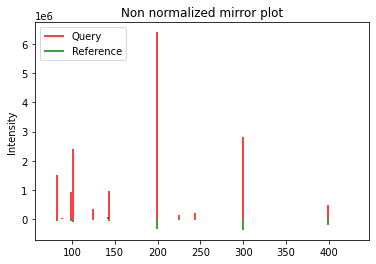

In [ ]:
for b in base_spec:
  plt.vlines(x = b[0], ymin = -b[1], ymax = 0,
            colors = 'green',
            label = 'Reference')
  
for q in query:
  plt.vlines(x = q[0], ymin = 0, ymax = q[1],
            colors = 'red',
            label = 'Query')
  
plt.title('Non normalized mirror plot')
plt.ylabel('Intensity')
leg = plt.legend(labels=['Query', 'Reference'], loc = 'upper left')
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('green') 

In [ ]:
np.array(base_spec)[:,1].max()

361648.28125

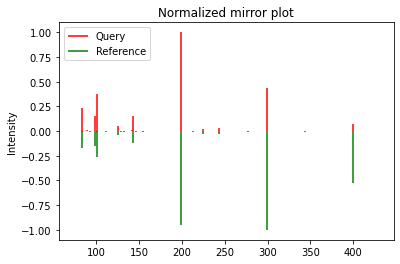

In [ ]:
# see reference https://gnps.ucsd.edu/ProteoSAFe/result.jsp?task=8ca7cad8b792439588aa5c38051ed6d5&view=view_all_annotations_DB#%7B%22main.%23Scan%23_lowerinput%22%3A%22114%22%2C%22main.%23Scan%23_upperinput%22%3A%22114%22%7D
mx = np.array(base_spec)[:,1].max()
for b in base_spec:
  plt.vlines(x = b[0], ymin = -b[1]/mx, ymax = 0,
            colors = 'green',
            label = 'Reference')

mx = np.array(query)[:,1].max()  
for q in query:
  plt.vlines(x = q[0], ymin = 0, ymax = q[1]/mx,
            colors = 'red',
            label = 'Query')
  
plt.title('Normalized mirror plot')
plt.ylabel('Intensity')
leg = plt.legend(labels=['Query', 'Reference'], loc = 'upper left')
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('green') 

In [ ]:
dbmatch.loc[4, ['SpectrumID', '#Scan#', 'MQScore']]

SpectrumID    CCMSLIB00003136497
#Scan#                       114
MQScore                 0.965109
Name: 4, dtype: object

## Entendendo como a rede espectral é construida e ilustrando uma "família molecular"

In [ ]:
import networkx as nx
import numpy as np

In [ ]:
net.head()

,CLUSTERID1,CLUSTERID2,ComponentIndex,Cosine,DeltaMZ
0,465,1125,1,0.9995,0.0
1,1125,1250,1,0.9959,0.0
2,197,1125,1,0.9956,0.0
3,1125,1302,1,0.9955,-0.0
4,465,1447,1,0.9983,0.0


In [ ]:
index_spectra = np.array([x['params']['feature_id'] for x in spectra])
index_spectra[:5]

array(['1', '2', '3', '4', '5'], dtype='<U4')

In [ ]:
np.where(index_spectra=='465')

(array([399]),)

In [ ]:
spectra[399]['params']['pepmass']

(167.0128, None)

In [ ]:
spec1 = []
for mz,it in zip(spectra[399]['m/z array'], spectra[399]['intensity array']):
    spec1.append([mz,it])

In [ ]:
np.where(index_spectra=='1125')

(array([938]),)

In [ ]:
spectra[938]['params']['pepmass']

(167.0127, None)

In [ ]:
spec2 = []
for mz,it in zip(spectra[938]['m/z array'], spectra[938]['intensity array']):
    spec2.append([mz,it])

In [ ]:
score_alignment(spec1, spec2, 167.0128, 167.0127, 0.02)

(0.9972260839379654,
 [Alignment(peak1=0, peak2=1),
  Alignment(peak1=1, peak2=3),
  Alignment(peak1=15, peak2=18),
  Alignment(peak1=5, peak2=8),
  Alignment(peak1=9, peak2=13),
  Alignment(peak1=20, peak2=25),
  Alignment(peak1=19, peak2=24),
  Alignment(peak1=3, peak2=5),
  Alignment(peak1=13, peak2=15),
  Alignment(peak1=14, peak2=17),
  Alignment(peak1=4, peak2=7),
  Alignment(peak1=22, peak2=27),
  Alignment(peak1=8, peak2=12),
  Alignment(peak1=24, peak2=32),
  Alignment(peak1=21, peak2=26),
  Alignment(peak1=17, peak2=20),
  Alignment(peak1=16, peak2=19),
  Alignment(peak1=12, peak2=14),
  Alignment(peak1=2, peak2=4),
  Alignment(peak1=18, peak2=21),
  Alignment(peak1=6, peak2=9),
  Alignment(peak1=23, peak2=30),
  Alignment(peak1=7, peak2=10)])

In [ ]:
# Criar um grafo apenas dos nós selecionados
net.rename(columns={'CLUSTERID1':'source', 'CLUSTERID2':'target'}, inplace=True)
G = nx.from_pandas_edgelist(net[['source', 'target']])
G

In [ ]:
net.ComponentIndex.value_counts()

10     271
8      189
3      139
54      91
20      89
      ... 
120      1
56       1
45       1
91       1
184      1
Name: ComponentIndex, Length: 138, dtype: int64

In [ ]:
# Número de nós em cada 'família molecular' ou sub-rede selecionada
conn = sorted(nx.connected_components(G), key = len, reverse=True)
[len(x) for x in conn]

[92,
 90,
 48,
 28,
 26,
 16,
 14,
 14,
 13,
 13,
 12,
 12,
 11,
 11,
 11,
 11,
 11,
 10,
 10,
 10,
 10,
 10,
 9,
 8,
 8,
 8,
 7,
 7,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [ ]:
# Seleciona uma família específica
g_c6 = G.subgraph(conn[5])

In [ ]:
# Oter as massas e tempos de retenção para os nós selecionados
gnps_c6 = gnps.loc[gnps['cluster index'].isin(conn[5]), ['cluster index', 'RTMean', 'parent mass', 'precursor mass']]
gnps_c6

,cluster index,RTMean,parent mass,precursor mass
11,12,1.8089,618.1466,618.1466
579,580,0.4970,618.1466,618.1466
685,686,8.4441,618.1465,618.1465
700,701,1.3313,618.1469,618.1469
708,709,1.1015,618.1468,618.1468
1008,1009,3.7078,618.1462,618.1462
1015,1016,4.1252,618.1462,618.1462
1023,1024,3.9084,618.1471,618.1471
1035,1036,4.3582,618.1463,618.1463
1045,1046,8.1684,618.1465,618.1465


In [ ]:
# Criar um dicionário mapeando o 'cluster index' --> 'parent mass', 'RTMean'
mapping = {}

for i  in gnps_c6.index:
    tmp = gnps_c6.loc[i, ['parent mass', 'RTMean']]
    mapping[gnps_c6.loc[i, 'cluster index']] = '\n'.join(map(str, round(tmp, 2)))

mapping

{12: '618.15\n1.81',
 580: '618.15\n0.5',
 686: '618.15\n8.44',
 701: '618.15\n1.33',
 709: '618.15\n1.1',
 1009: '618.15\n3.71',
 1016: '618.15\n4.13',
 1024: '618.15\n3.91',
 1036: '618.15\n4.36',
 1046: '618.15\n8.17',
 1085: '618.15\n5.09',
 1123: '618.15\n5.1',
 1152: '618.15\n0.56',
 1382: '618.15\n8.12',
 1422: '618.15\n4.97',
 1454: '618.15\n5.27'}

{'618.15\n0.5': Text(0.2586330048327019, -0.10602206062198916, '618.15\n0.5'),
 '618.15\n0.56': Text(0.16738209384836006, -0.04293363814391382, '618.15\n0.56'),
 '618.15\n1.1': Text(0.7430809440349658, 0.015656548978268903, '618.15\n1.1'),
 '618.15\n1.33': Text(0.030134823659709584, -0.015332352730391074, '618.15\n1.33'),
 '618.15\n1.81': Text(0.17902398954328563, -0.1559734617898303, '618.15\n1.81'),
 '618.15\n3.71': Text(0.318357280760568, -0.23083023927751917, '618.15\n3.71'),
 '618.15\n3.91': Text(0.2695968695107016, -0.021247486640223315, '618.15\n3.91'),
 '618.15\n4.13': Text(0.2315763204778017, 0.05600451060683795, '618.15\n4.13'),
 '618.15\n4.36': Text(0.058074059747901925, 0.05831825229829235, '618.15\n4.36'),
 '618.15\n4.97': Text(-0.24461701010457437, 0.19581417041750945, '618.15\n4.97'),
 '618.15\n5.09': Text(-0.6861650384758726, 0.38028906148281844, '618.15\n5.09'),
 '618.15\n5.1': Text(-1.0, 0.35867938464792987, '618.15\n5.1'),
 '618.15\n5.27': Text(-0.8987854484229185, 0

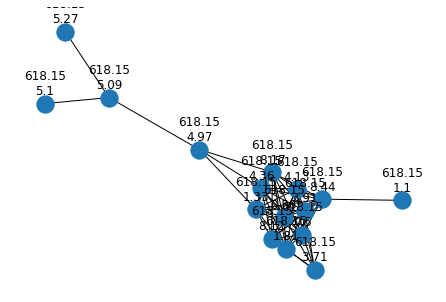

In [ ]:
# gráfico com massa e tempo de retenção
g_c6 = nx.relabel_nodes(g_c6, mapping)
pos = nx.spring_layout(g_c6)
nx.draw(g_c6, pos, font_size=16)

for p in pos:  # raise text positions
    pos[p][1] += 0.07
nx.draw_networkx_labels(g_c6, pos)